In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall
import PyPlot; const plt = PyPlot ;
include("../saftvrmienn.jl") ;

In [3]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1) ;

In [4]:
header_names = ["epoch", "species", "Mw", "m", "σ", "λ_a", "λ_r", "ϵ"]
# raw_params = CSV.File("../params_log_all_alkanes_sat_v_500_epochs.csv"; header=header_names) |> DataFrame
raw_params = CSV.File("params_data_1k_iters.txt"; header=header_names) |> DataFrame ;

In [5]:
unique_values = unique(raw_params[!, :species])
num_rows = length(unique_values)

processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    m = fill([0.0], num_rows), 
    σ = fill([0.0], num_rows),
    λ_a = fill([0.0], num_rows),
    λ_r = fill([0.0], num_rows),
    ϵ = fill([0.0], num_rows)
) ;

processed_data.species = unique_values ;

In [6]:
for i in unique_values
    raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
    num_epochs = nrow(raw_params_spec)

    row_number_processed = findall(isequal(i), processed_data.species)
    row_number_source = findall(isequal(i), pcp_source_params.species)

    processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
    processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
    processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs]]
    processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs]]
    processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs]]
    processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs]]
    processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs]]
    
end

processed_data = sort(processed_data, :Mw) ;

In [7]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name) ;
processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), processed_data) 
processed_data_lin_alkanes = sort(processed_data_lin_alkanes, :Mw) ;

# raw_params_spec = filter(row -> contains(row.species, i), raw_params)

151


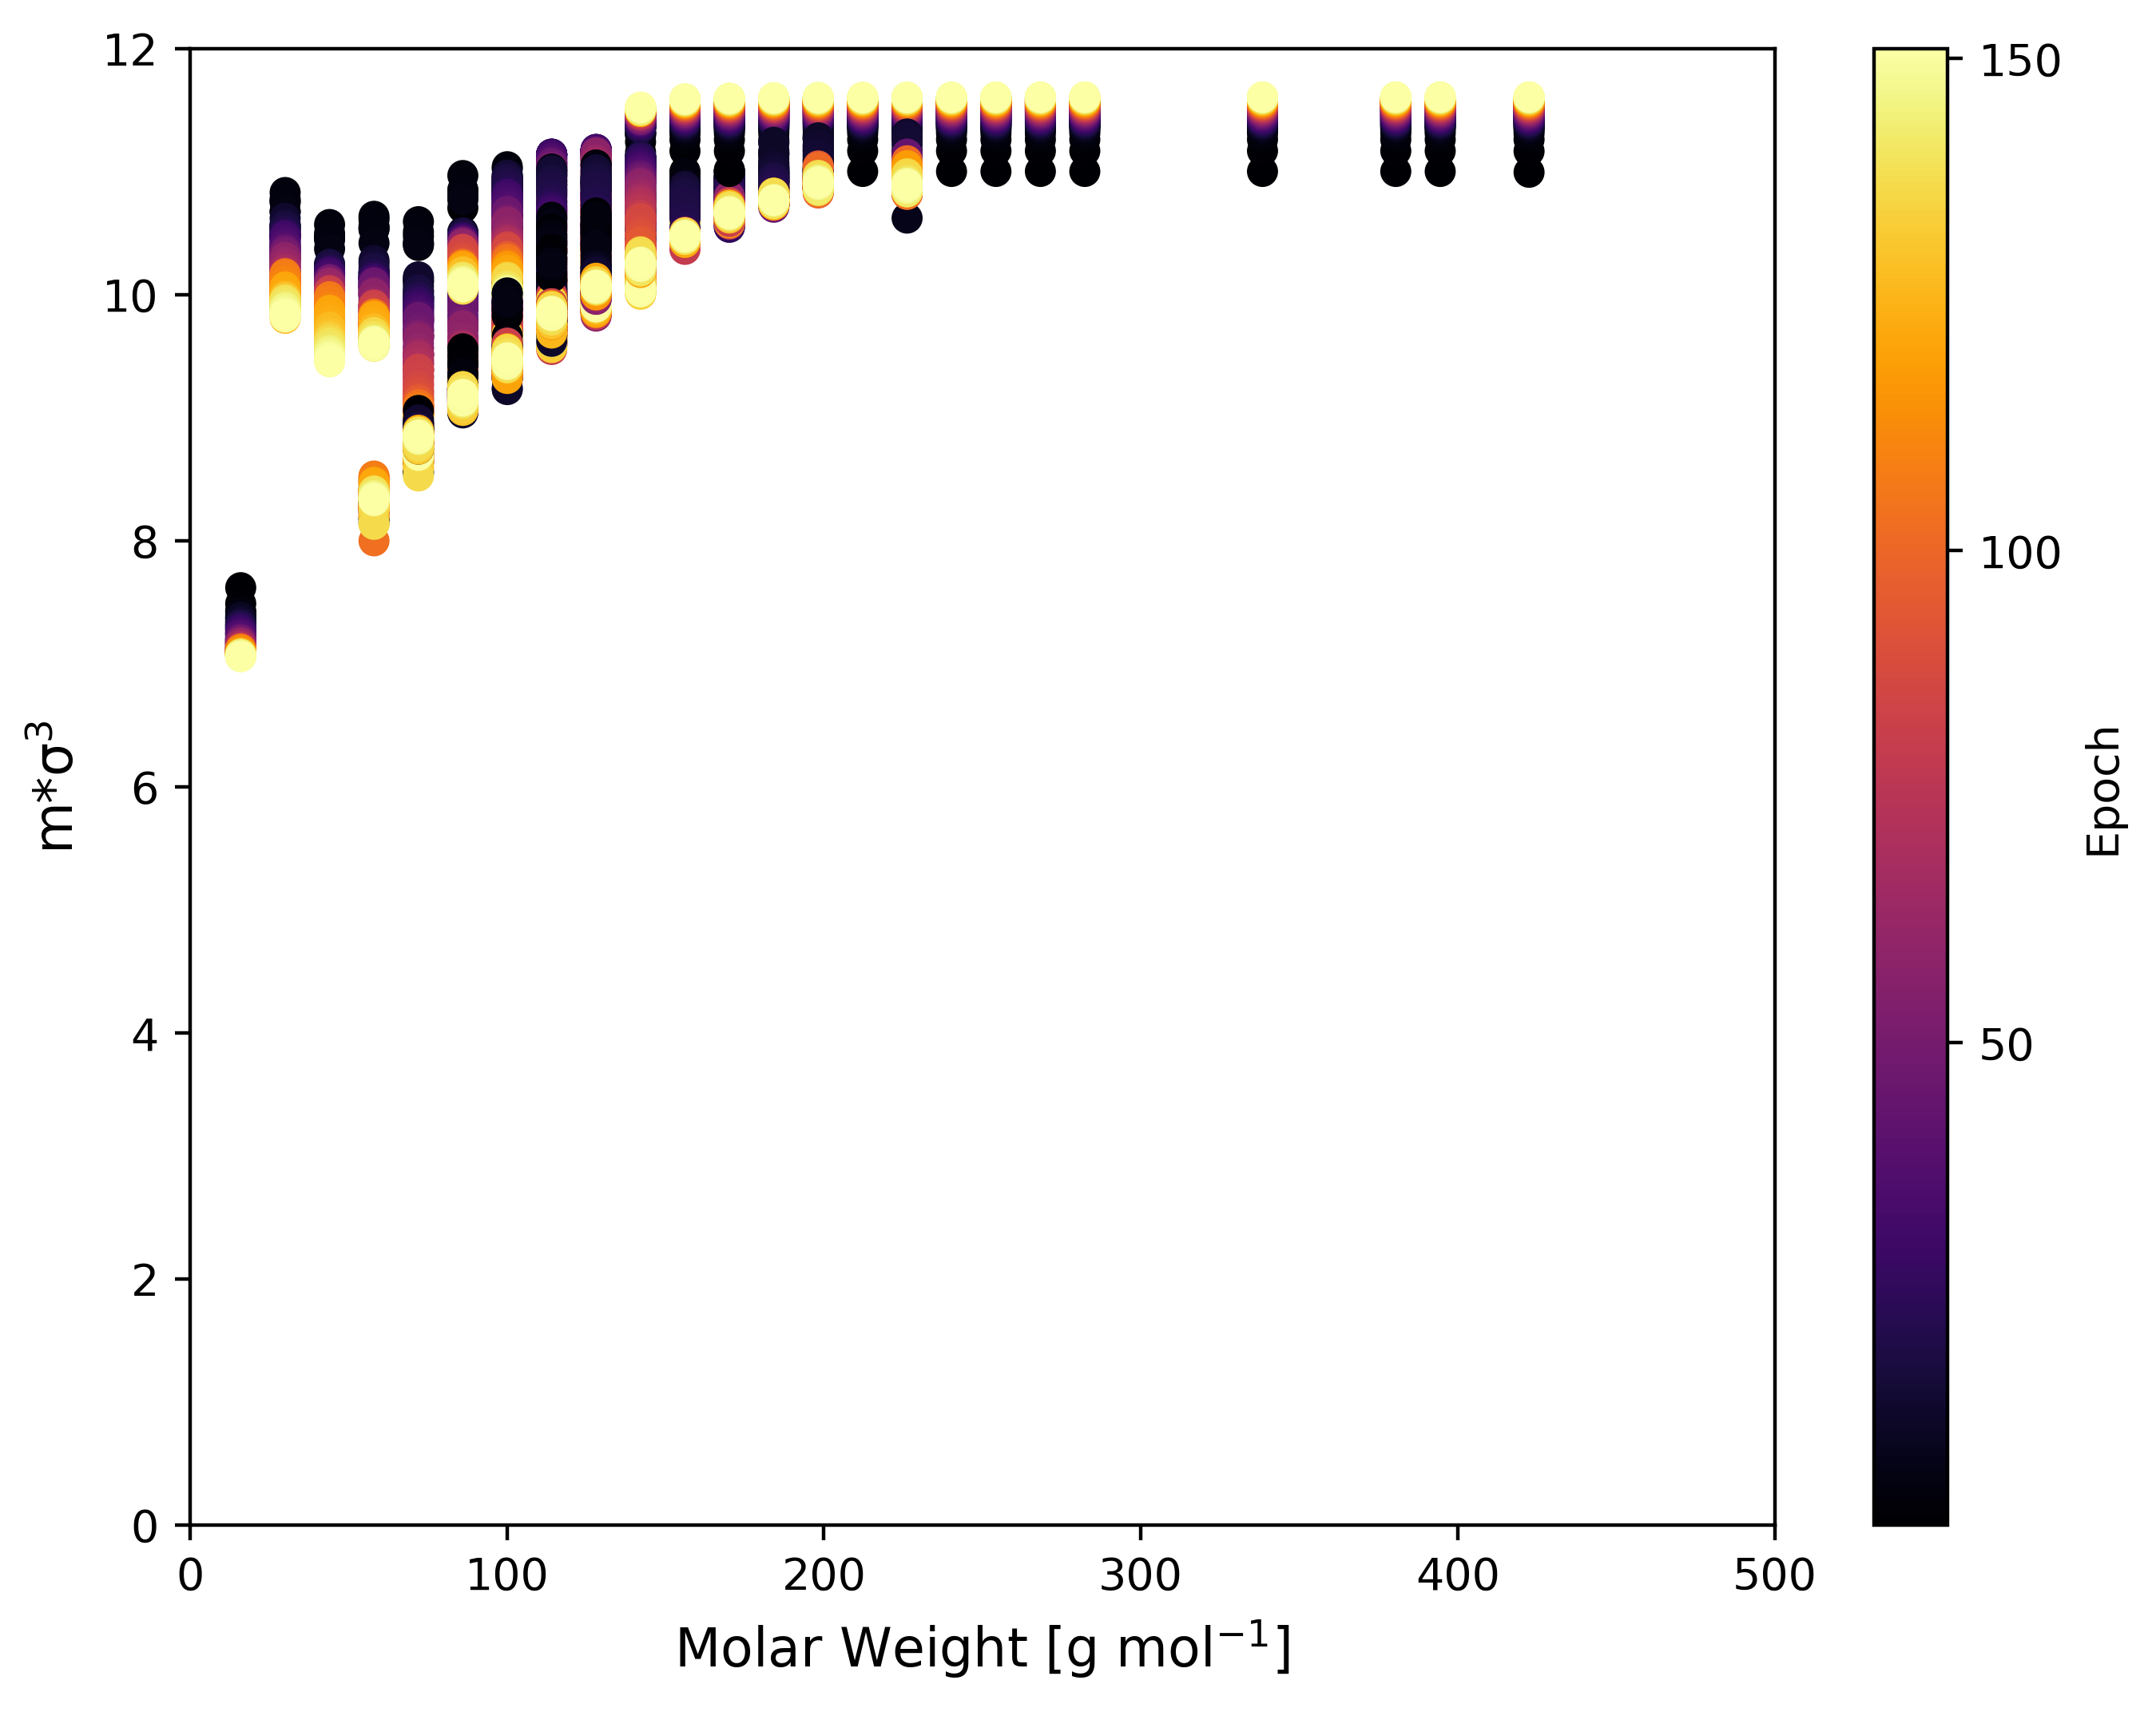

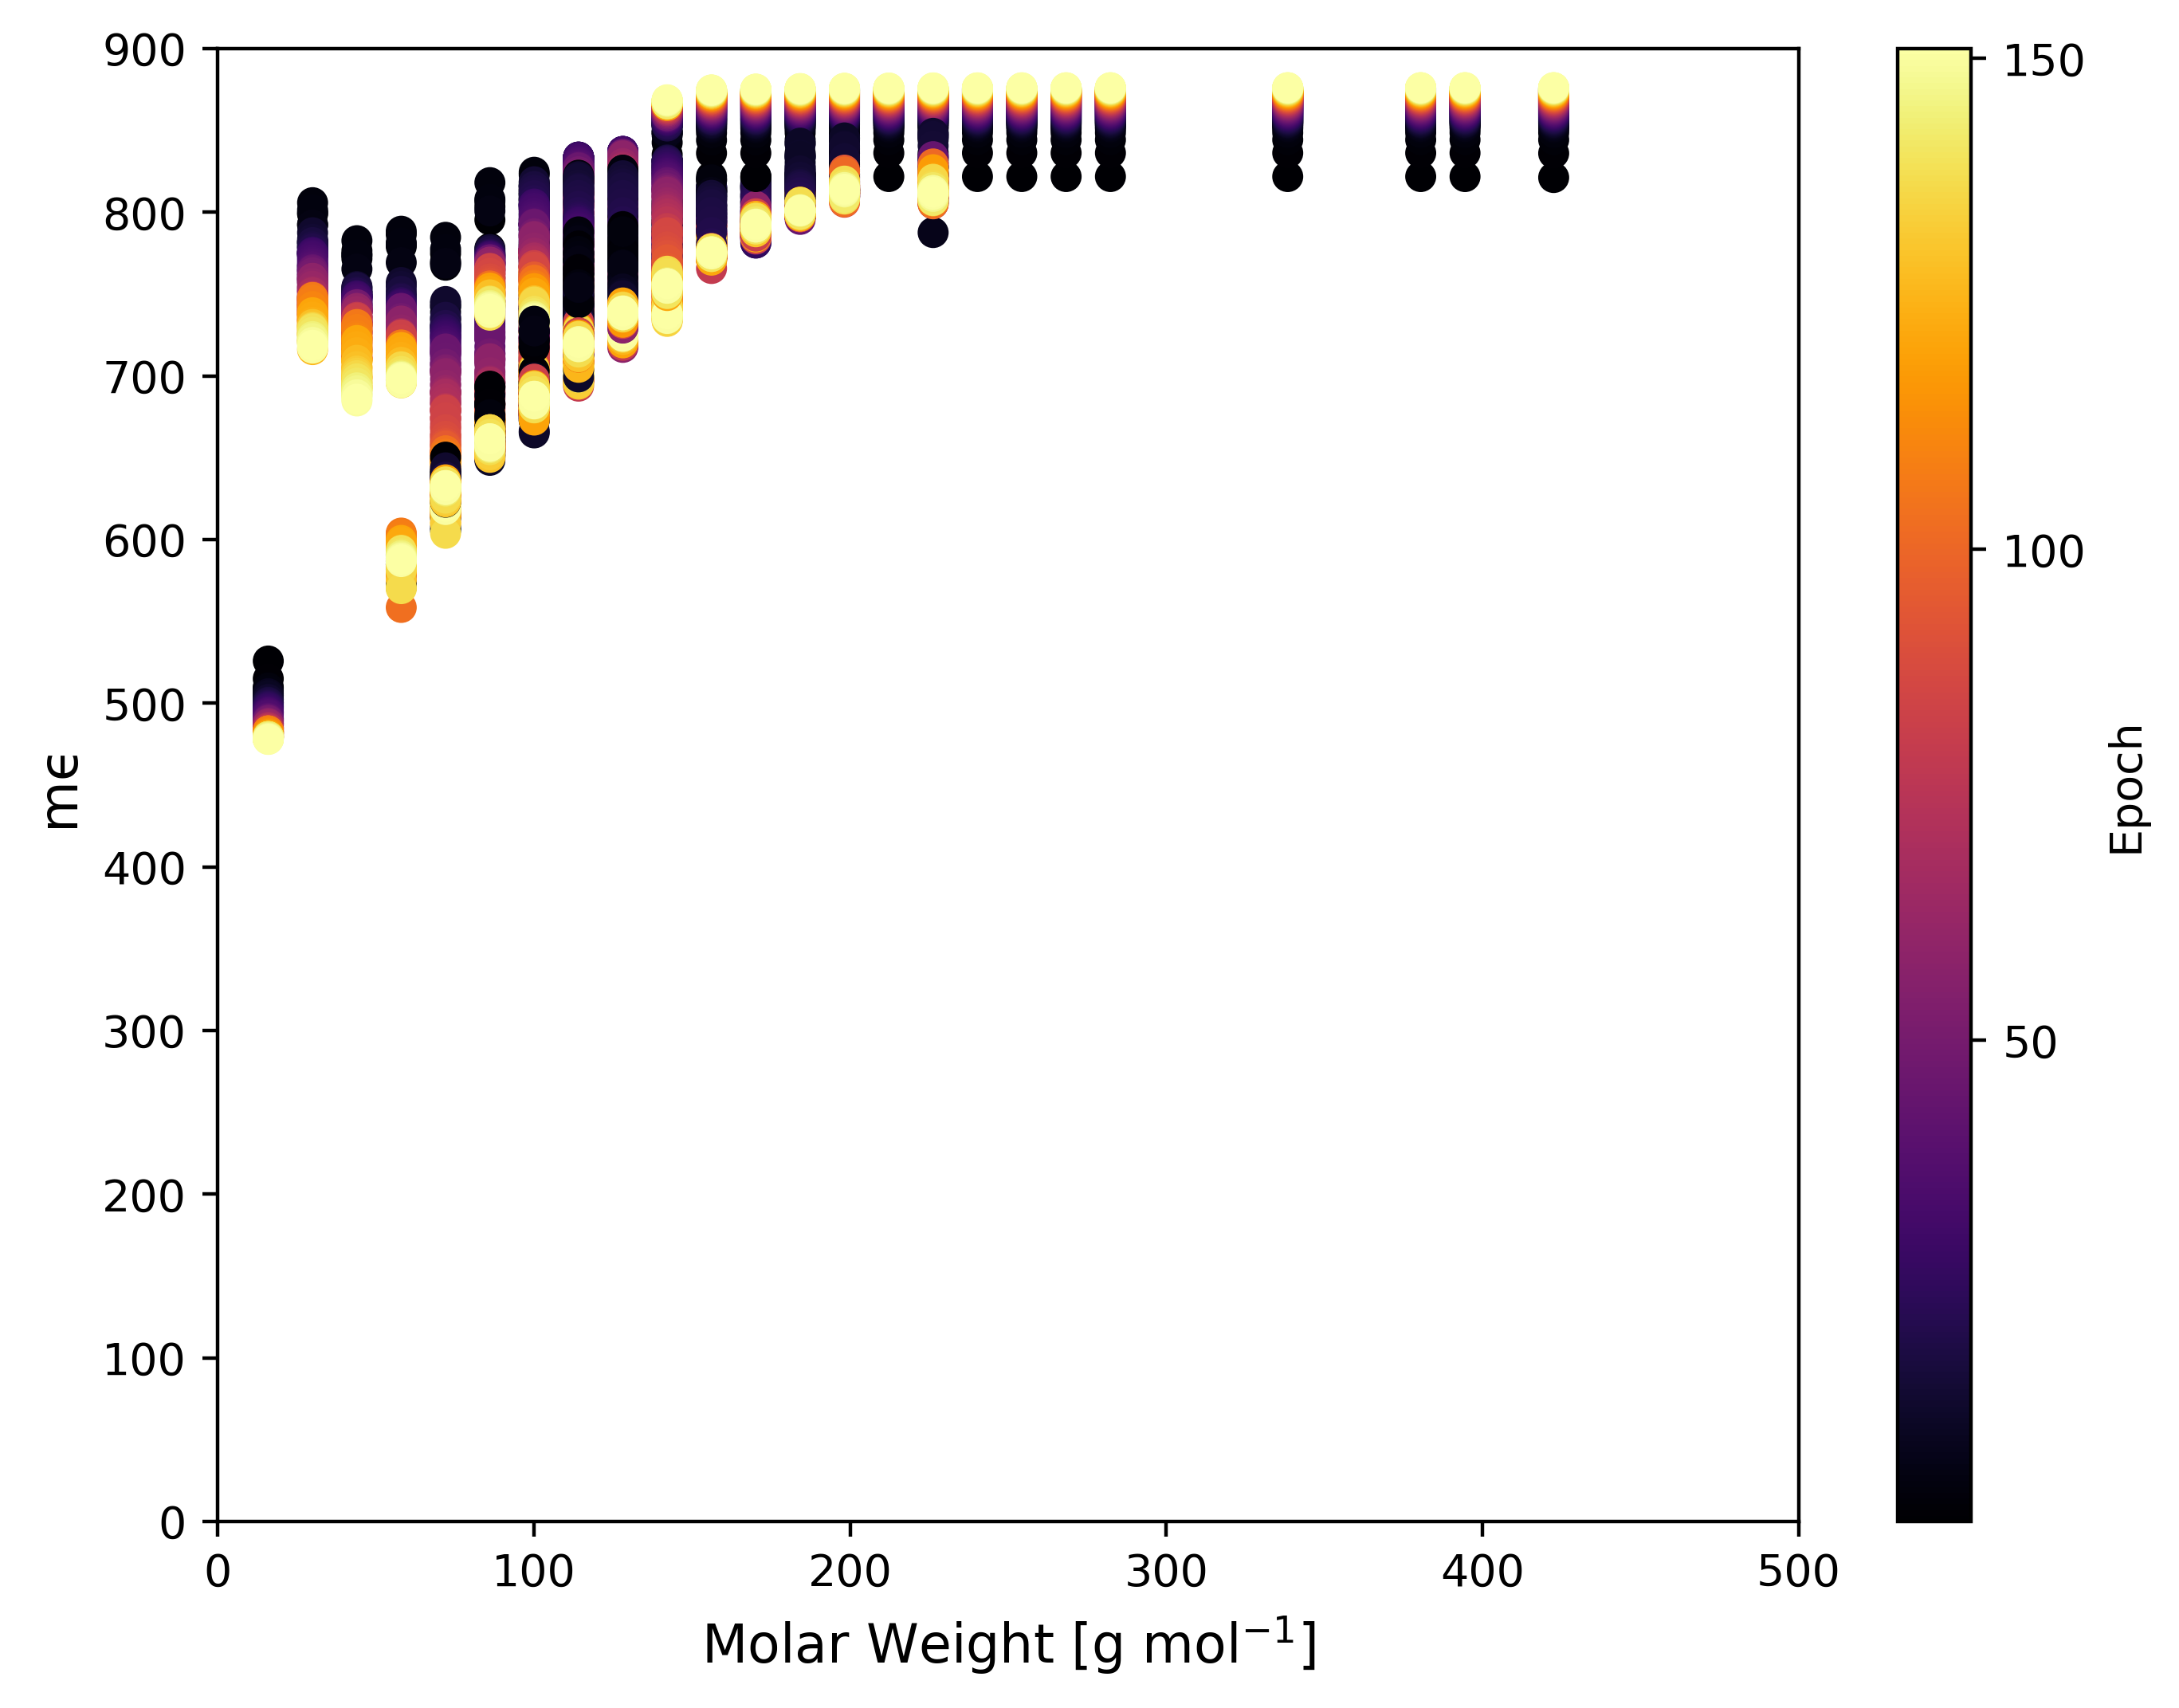

(0.0, 500.0)

In [10]:
num_epochs = length(processed_data[1,:m])
# mσ^3 
plt.figure(figsize=(8, 6), dpi=400)

color_mapping = collect(range(1,num_epochs))

for j = 1:nrow(processed_data)

    mol_weight = fill(processed_data[j,:Mw], num_epochs)
    ms = processed_data[j,:m]
    σs = processed_data[j,:σ]

    m_sigmacubed = [ms[i]*σs[i] for i in 1:num_epochs]

    plt.scatter(mol_weight, m_sigmacubed, c=color_mapping, cmap="inferno")
end

plt.colorbar(ticks = 0:50:num_epochs,label = "Epoch")

plt.xlabel("Molar Weight [g mol\$^{-1}\$]",fontsize=12)
plt.ylabel("m*σ\$^3\$",fontsize=12)
plt.ylim([0,12])
plt.xlim([0,500]) ;

# mϵ 
plt.figure(figsize=(8, 6), dpi=400)

color_mapping = collect(range(1,num_epochs))

for j = 1:nrow(processed_data)

    mol_weight = fill(processed_data[j,:Mw], num_epochs)
    ms = processed_data[j,:m]
    ϵs = processed_data[j,:ϵ]

    m_epsilon = [ms[i]*ϵs[i] for i in 1:num_epochs]

    plt.scatter(mol_weight, m_epsilon, c=color_mapping, cmap="inferno")
end

plt.colorbar(ticks = 0:50:num_epochs,label = "Epoch")

plt.xlabel("Molar Weight [g mol\$^{-1}\$]",fontsize=12)
plt.ylabel("mϵ",fontsize=12) ;
plt.ylim([0,900])
plt.xlim([0,500]) ;   

# plt.savefig("all_compound_phase_envelopes.png",dpi=400)

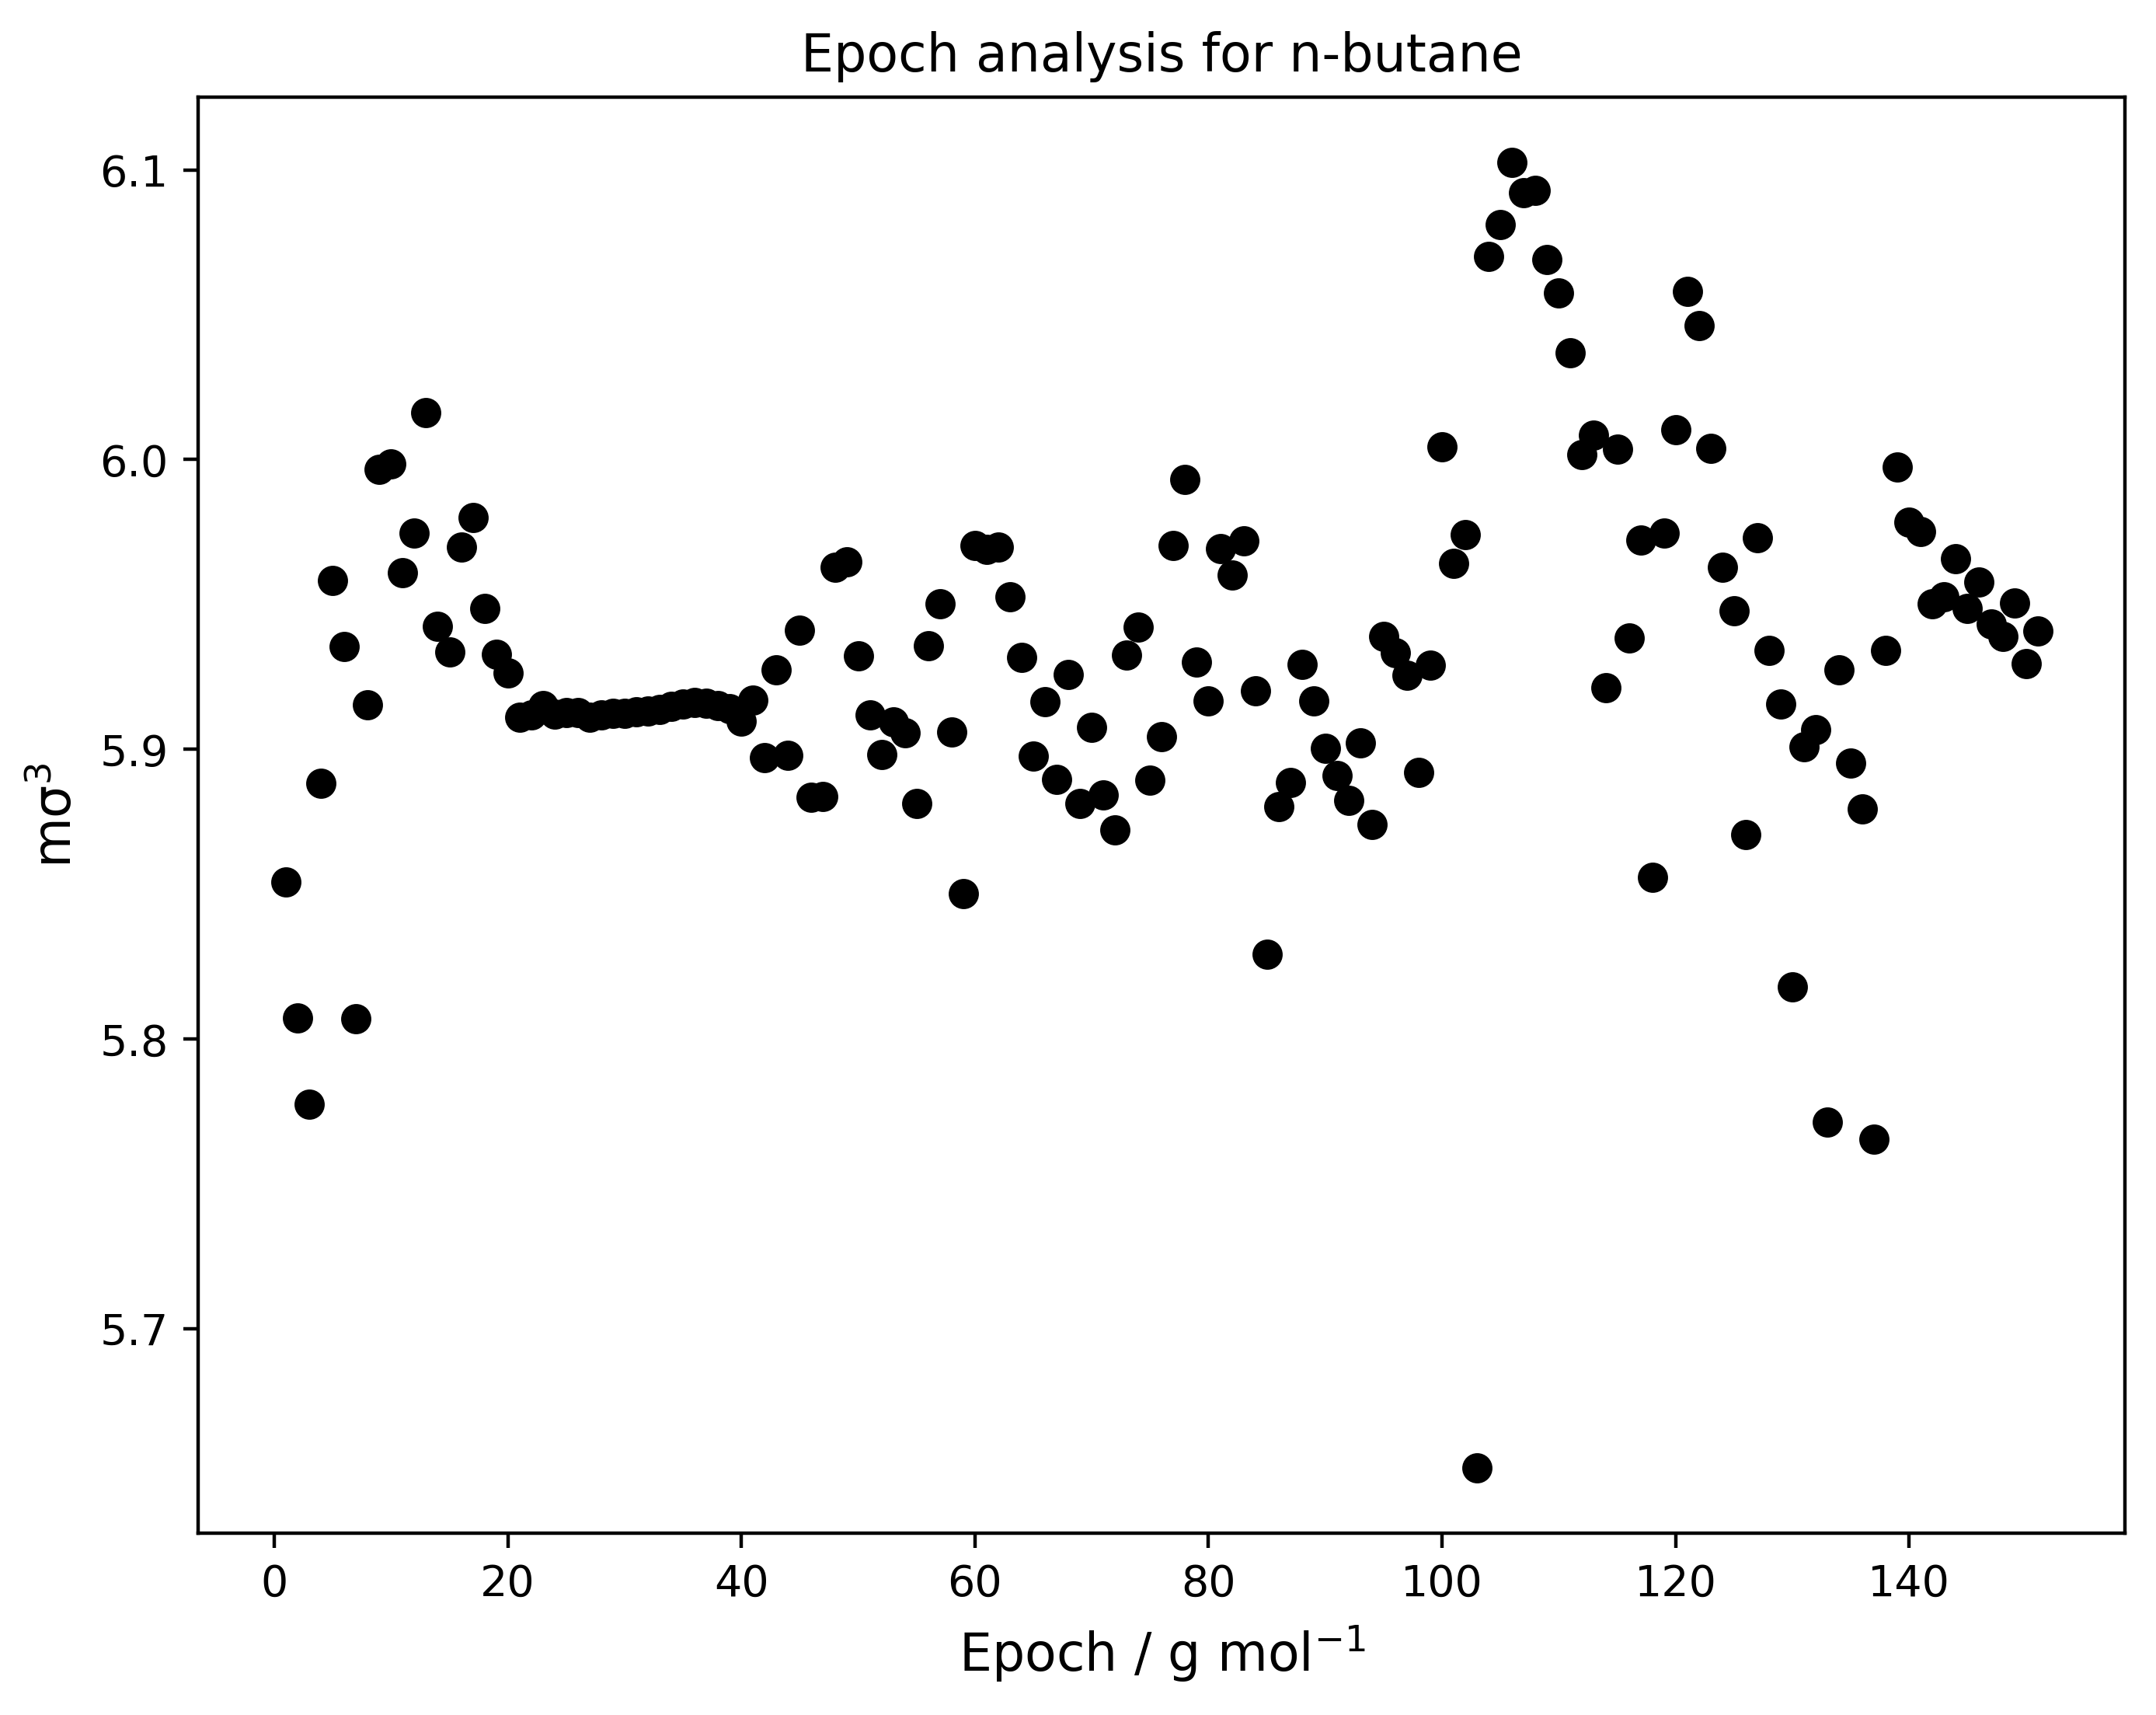

In [35]:
test_species = "n-butane"
num_epochs = length(processed_data[1,:m])
epochs = collect(range(1,num_epochs))

processed_data_test_species = filter(row -> isequal(row.species, lowercase(test_species)), processed_data)

ms = processed_data_test_species[1,:m]
ϵs = processed_data_test_species[1,:m]
σs = processed_data_test_species[1,:m]

m_epsilon = [ms[i]*ϵs[i] for i in 1:num_epochs]
m_sigma_cubed = [ms[i]*σs[i] for i in 1:num_epochs]

plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(epochs, m_sigma_cubed, color = "k")

plt.xlabel("Epoch / g mol\$^{-1}\$",fontsize=12)
plt.ylabel("mσ\$^3\$",fontsize=12) ;
plt.title("Epoch analysis for "* test_species) ;
# plt.ylim([0,900])
# plt.xlim([0,500]) ;  


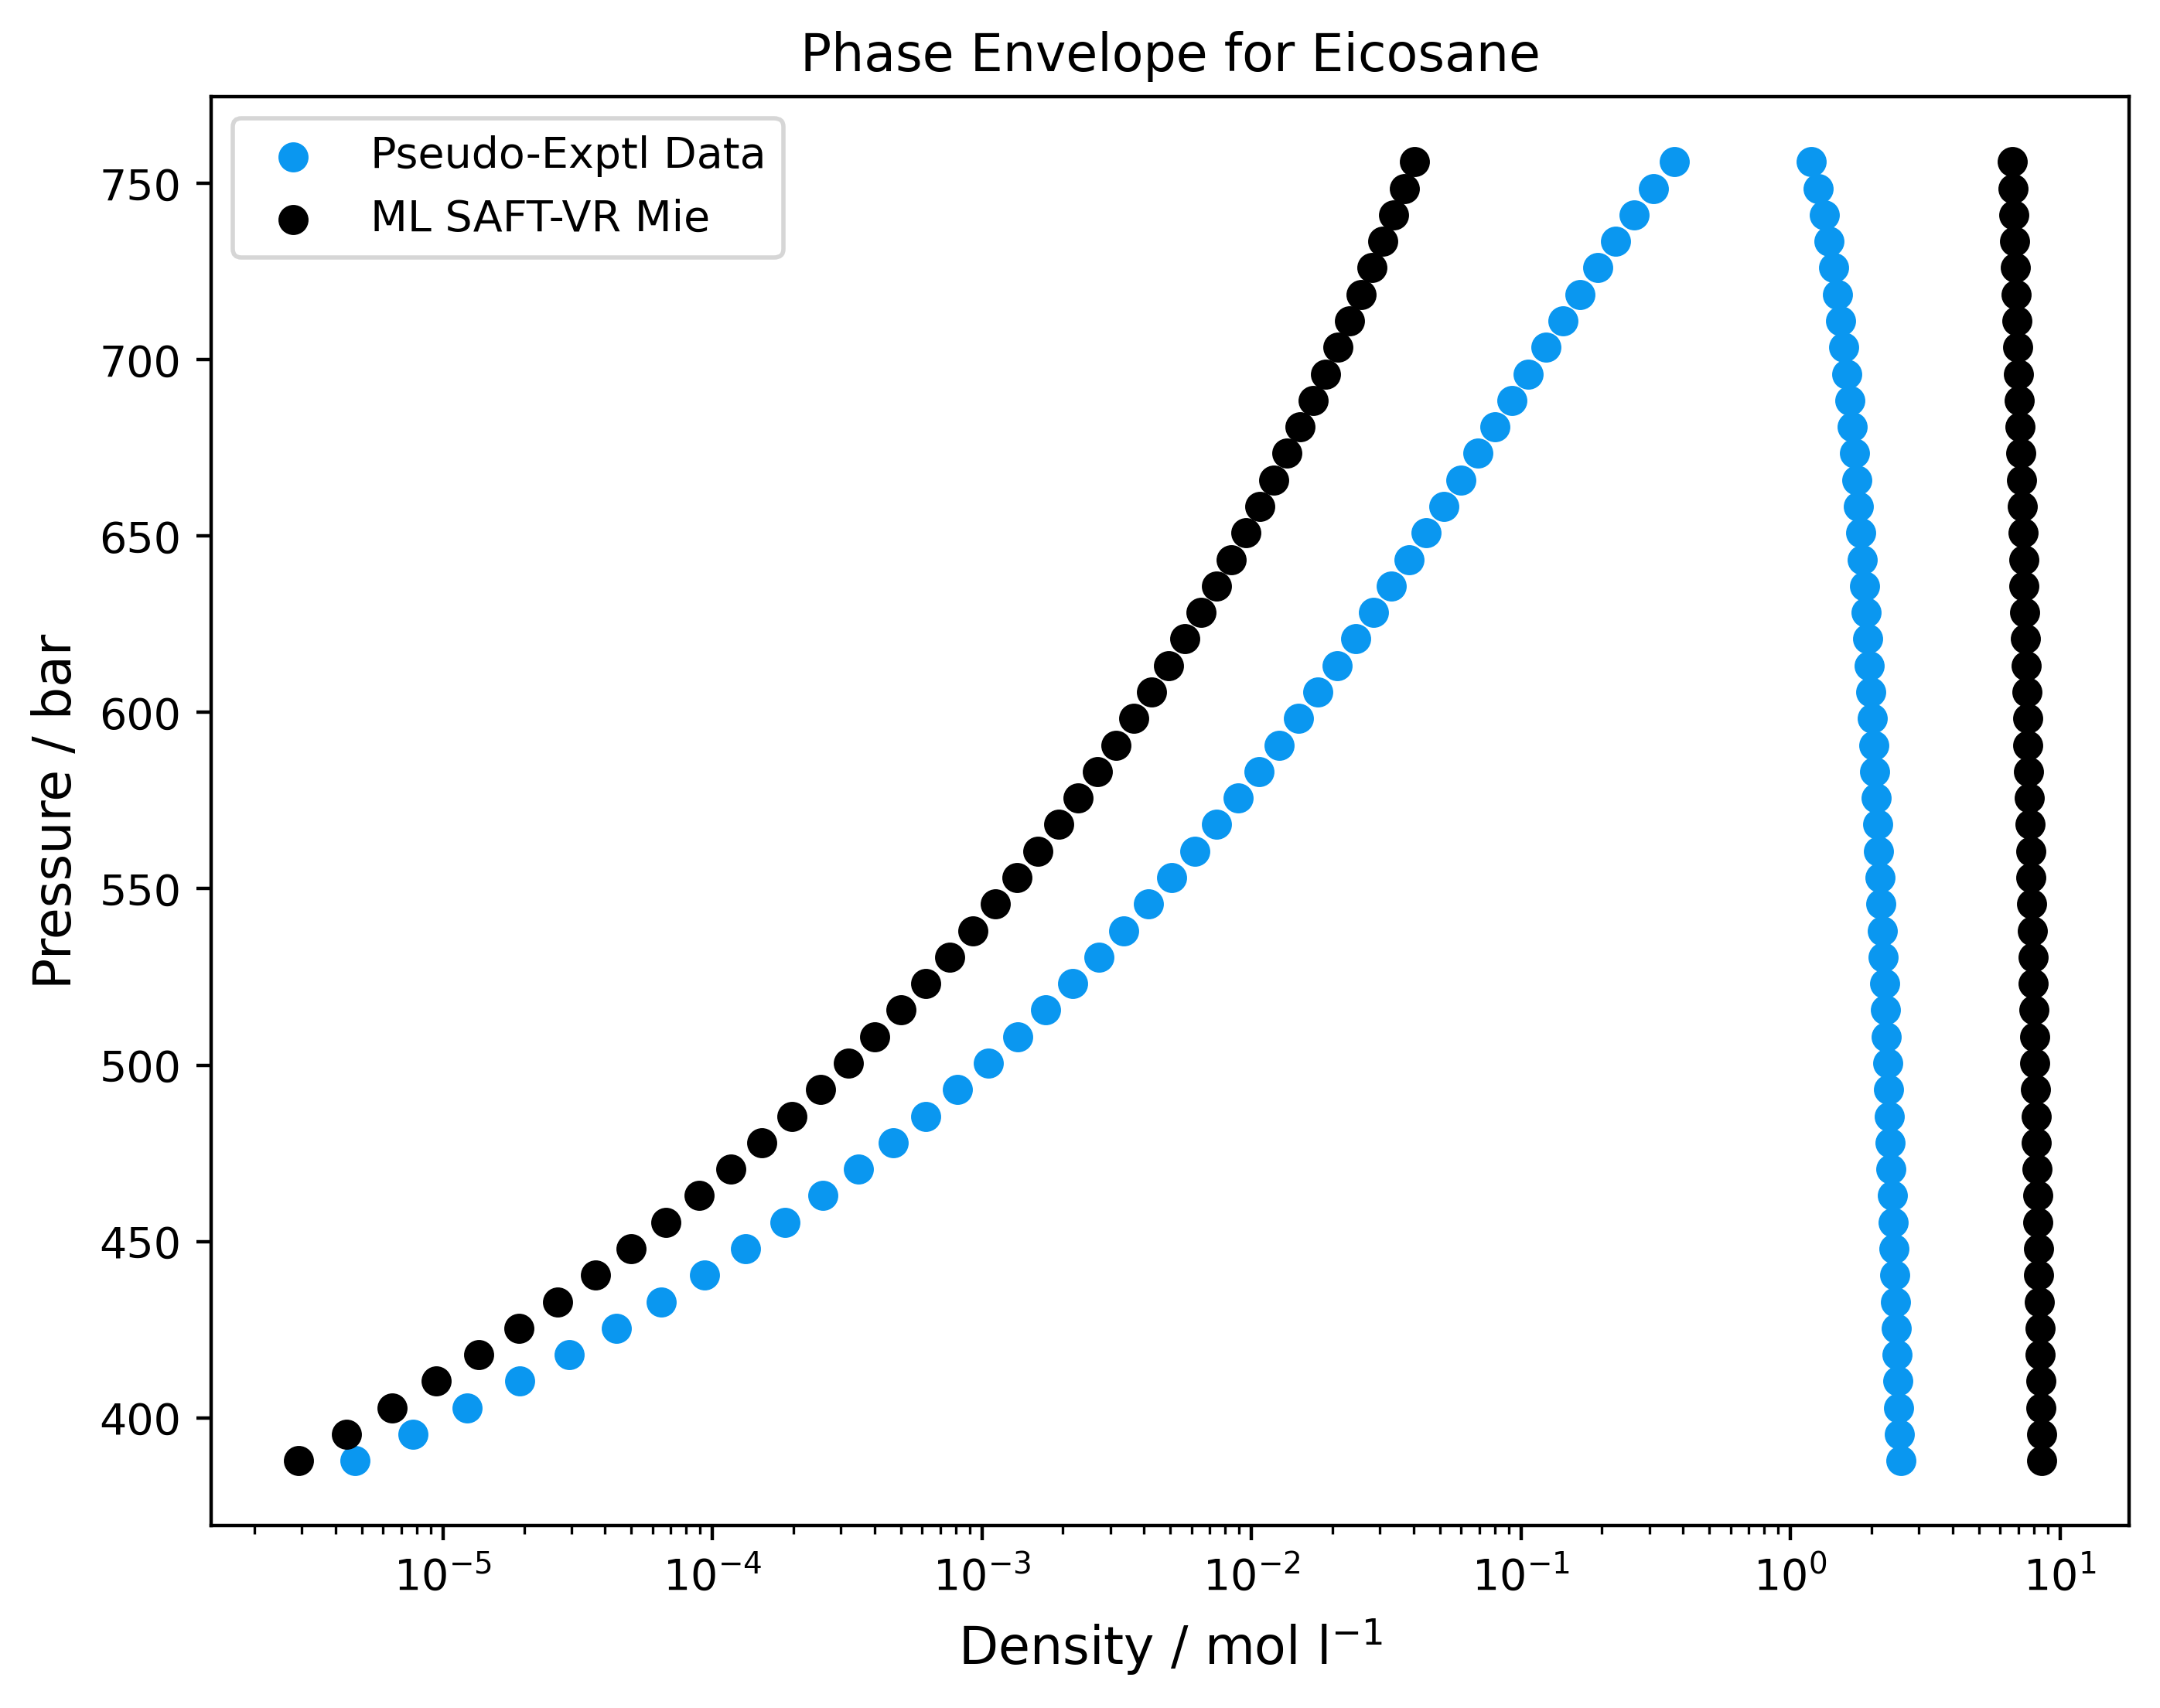

In [9]:
# Plot source pcp saft phase envelope (over given temperature range)

test_species = string("Eicosane")

pcp_model = PPCSAFT([test_species])
Tc, pc, Vc = crit_pure(pcp_model)
T_range = range(0.5 * Tc, 0.975 * Tc, 50)
v_liq_range_pcp = []
v_vap_range_pcp = []
v_liq_range_vrmie = []
v_vap_range_vrmie = []

for T in T_range
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
    push!(v_liq_range_pcp, v_liq_sat)
    push!(v_vap_range_pcp, v_vap_sat)
end

processed_data_test_species = filter(row -> isequal(row.species, lowercase(test_species)), processed_data)

Mw_test_species = processed_data_test_species[1,:Mw]
m_test_species = processed_data_test_species[1,:m][end]
σ_test_species = processed_data_test_species[1,:σ][end]
λ_a_test_species = processed_data_test_species[1,:λ_a][end]
λ_r_test_species = processed_data_test_species[1,:λ_r][end]
ϵ_test_species = processed_data_test_species[1,:ϵ][end]

vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)

for T in T_range
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T)
    push!(v_liq_range_vrmie, v_liq_sat)
    push!(v_vap_range_vrmie, v_vap_sat)
end


plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(1e-3 ./v_liq_range_pcp, T_range,color="#0a97f0")
plt.scatter(1e-3 ./v_liq_range_vrmie, T_range,color="k")

plt.xscale("log")
plt.title("Phase Envelope for " * test_species)
plt.xlabel("Density / mol l\$^{-1}\$",fontsize=12)
plt.ylabel("Pressure / bar",fontsize=12)
plt.legend(["Pseudo-Exptl Data","ML SAFT-VR Mie"])

plt.scatter(1e-3 ./v_vap_range_pcp, T_range,color="#0a97f0")
plt.scatter(1e-3 ./v_vap_range_vrmie, T_range,color="k") ;